## Fully-conected neuronal network

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
WORKING_PATH = '/content/drive/MyDrive/KeepCoding/DeepLearning/exercise'
OUTPUTDIR = '2_FCNN'
NAMESTUDY = 'fcnn'

In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/KeepCoding/DeepLearning/exercise


In [ ]:
!pip install optuna
#!pip install -r requirements.tx

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import optuna
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to load custom libraries
sys.path.append(WORKING_PATH)

# load custom libraries
from utilsSingleNN import *

# load dataset
poi_data = pd.read_csv(os.path.join(WORKING_PATH, "poi_dataset.csv"))

set_random_seed()

In [ ]:
# split data into train, val and test datasets
df_train, df_test = train_test_split(poi_data, test_size = 0.2, random_state = 16)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16)
print(f'Number of samples.')
print(f'Train dataset: {df_train.shape[0]}')
print(f'Validation dataset: {df_val.shape[0]}')
print(f'Test dataset: {df_test.shape[0]}')

Number of samples.
Train dataset: 1004
Validation dataset: 251
Test dataset: 314


In [ ]:
# calculate engagement score
df_engagement = df_train[['Visits','Bookmarks','Likes','Dislikes']].copy()
df_engagement['Likes_Dislikes'] = df_engagement['Likes'] - df_engagement['Dislikes']
df_engagement = df[['Visits','Likes_Dislikes']]
scaler_engagement = MinMaxScaler().fit(df_engagement)

# Calculate scores
def categorize_score(x):
  if x < 0.29:
    return 0
  else:
    return 1


In [ ]:
# Normalize xps, locationLon, locationLat, numTags
scaler_features = StandardScaler().fit(df_train[['xps','locationLon','locationLat']])

# one hot encoder for categories
onehot_encoder_categories = MultiLabelBinarizer().fit(poi_data['categories'].apply(eval))

# One hot encoder for tier
onehot_encoder_tier = OneHotEncoder(sparse_output=False).fit(pd.DataFrame(poi_data['tier']))


In [ ]:
def processdata(df):
  """
  Data processing steps before being used in the model.
  Same steps are applied to train, validation and test datasets.
  Processing include:
  - Calculate number of tags
  - One hot encoding for categories
  - Calculate engagement feature (low, medium, high)
  - Scale quantitative features
  - One hot encoding for tier
  - Remove features
  """
  df.index = range(df.shape[0])
  # Feature for number of tags
  df['NumTags'] = df['tags'].apply(eval).apply(len)
  # One hot encoder for categories
  categories_one_hot = onehot_encoder_categories.transform(df['categories'].apply(eval))
  df_categories_one_hot = pd.DataFrame(categories_one_hot, columns=onehot_encoder_categories.classes_)
  df = pd.concat([df, df_categories_one_hot], axis=1)
  # Engagement features
  df['Likes_Dislikes'] = df['Likes'] - df['Dislikes']
  df_engagement = df[['Visits','Likes_Dislikes']]
  df['Score']= scaler_engagement.transform(df_engagement).sum(axis = 1)/2
  df['engagement'] = df['Score'].apply(categorize_score)
  # Scale features xps, locationLon, locationLat
  df[['xps','locationLon','locationLat']] = scaler_features.transform(df[['xps','locationLon','locationLat']])
  # One hot encoder for tier
  tier_one_hot = onehot_encoder_tier.transform(pd.DataFrame(df['tier']))
  df_tier_one_hot = pd.DataFrame(tier_one_hot, columns=onehot_encoder_tier.get_feature_names_out(['tier']))
  df = pd.concat([df, df_tier_one_hot], axis=1)
  # Remove features
  df_clean = df.drop(['tags','categories','id','name','shortDescription',
                      'main_image_path','Likes','Dislikes','Bookmarks','Visits','Score', 'Likes_Dislikes', 'tier'], axis = 1)
  return df_clean

In [ ]:
# apply data processing steps to train, validation and test data
df_train_proc = processdata(df_train)
df_val_proc = processdata(df_val)
df_test_proc = processdata(df_test)

In [ ]:
df_train_proc.head().T
#df_train_proc.shape

,0,1,2,3,4
locationLon,-0.120490,-0.117211,0.105835,0.781224,-0.122874
locationLat,0.047806,0.045798,1.140640,0.629218,0.044949
xps,0.242539,-0.651893,1.136970,1.136970,-1.993540
NumTags,13.000000,13.000000,1.000000,1.000000,10.000000
Arquitectura,1.000000,0.000000,1.000000,0.000000,0.000000
Ciencia,0.000000,0.000000,0.000000,0.000000,0.000000
Cine,0.000000,0.000000,0.000000,0.000000,0.000000
Cultura,0.000000,1.000000,1.000000,1.000000,1.000000
Escultura,0.000000,1.000000,0.000000,0.000000,1.000000
Gastronomía,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Dataset
class FCNDataset(Dataset):
  def __init__(self, engagement, features, transform=None):
    self.engagement = torch.tensor(engagement)
    self.features = torch.tensor(features.values, dtype=torch.float32)
    self.transform = transform

  def __len__(self):
        return len(self.engagement)

  def __getitem__(self, idx):
        features = self.features
        engagement = self.engagement
        return features[idx], engagement[idx]

In [ ]:
train_dataset = FCNDataset(df_train_proc['engagement'], df_train_proc.drop(['engagement'], axis=1))
val_dataset = FCNDataset(df_val_proc['engagement'], df_val_proc.drop(['engagement'], axis=1))
test_dataset = FCNDataset(df_test_proc['engagement'], df_test_proc.drop(['engagement'], axis=1))

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.01
dropout_rate = 0.2

In [ ]:
# Define Fully-connected NN
class FCNN(nn.Module):
    def __init__(self, dropout_rate):
        super(FCNN, self).__init__()
        # First fully connected layer
        self.layer1 = nn.Sequential(
            nn.Linear(20, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Output fully connected layer
        self.layer2 = nn.Sequential(
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x

Device: cpu
Epoch 1, Loss: 0.8114079236984253, Acc: 64.8406374501992, Val Loss: 0.6920192539691925, Val Acc: 77.29083665338645, LR: 0.01
Epoch 2, Loss: 0.6603232994675636, Acc: 75.199203187251, Val Loss: 0.6677204966545105, Val Acc: 77.29083665338645, LR: 0.01
Epoch 3, Loss: 0.6373671516776085, Acc: 74.60159362549801, Val Loss: 0.6183411478996277, Val Acc: 75.2988047808765, LR: 0.01
Epoch 4, Loss: 0.6018255352973938, Acc: 74.30278884462152, Val Loss: 0.6040749847888947, Val Acc: 76.89243027888446, LR: 0.01
Epoch 5, Loss: 0.6028110831975937, Acc: 75.199203187251, Val Loss: 0.5879976153373718, Val Acc: 77.29083665338645, LR: 0.01
Epoch 6, Loss: 0.5931808613240719, Acc: 75.99601593625498, Val Loss: 0.5926571190357208, Val Acc: 77.29083665338645, LR: 0.01
Epoch 7, Loss: 0.5892520397901535, Acc: 75.59760956175299, Val Loss: 0.6001810729503632, Val Acc: 77.29083665338645, LR: 0.01
Epoch 8, Loss: 0.5887086912989616, Acc: 75.59760956175299, Val Loss: 0.6039659082889557, Val Acc: 77.29083665338

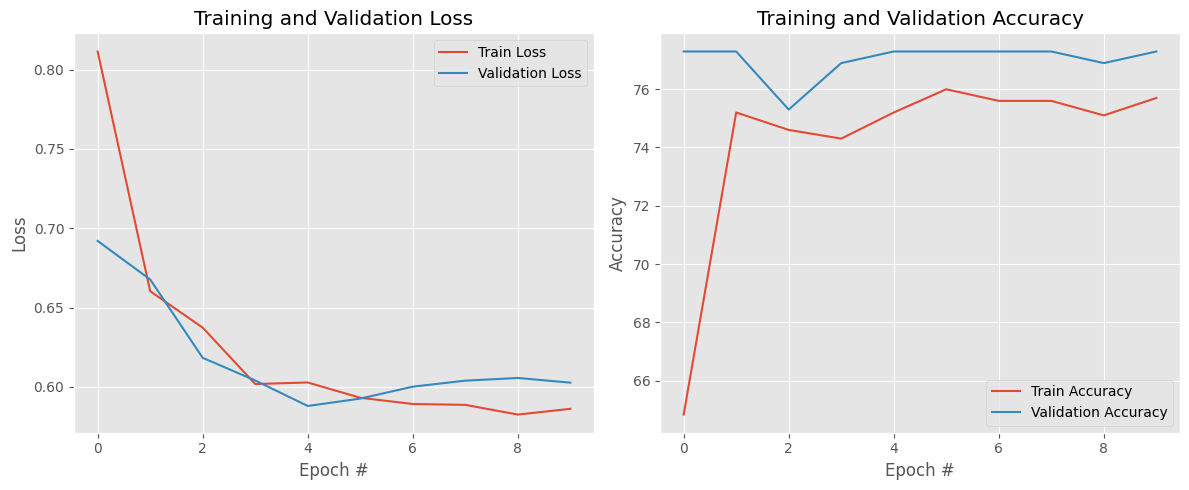

In [ ]:
# train model (check if model is ok)
set_random_seed()
model = FCNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)


In [ ]:
def objective(trial):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)

    # define dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # build model and move to device
    model = FCNN(dropout_rate).to(device)

    # optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # init list for output values
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # train model
    for epoch in range(num_epochs):
        train_loss, train_acc, _ = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # save output from training and validation
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # save output to a file
    output_metrics_file = os.path.join(WORKING_PATH,OUTPUTDIR,f"metrics_{trial.number}.pkl")
    with open(output_metrics_file, "wb") as f:
        pickle.dump({"train_losses": train_losses,
                     "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs}, f)

    # save path for output as user parameter
    trial.set_user_attr("metrics_path", output_metrics_file)

    return val_accs[-1]

In [ ]:
# build optuna study
# remove study if exists
try:
    optuna.delete_study(study_name = NAMESTUDY + "_optimization", storage=os.path.join("sqlite:///", OUTPUTDIR, NAMESTUDY + "_study.sqlite3"))
except:
    pass

study = optuna.create_study(study_name = NAMESTUDY + "_optimization", direction="maximize",
                            storage=os.path.join("sqlite:///", OUTPUTDIR, NAMESTUDY + "_study.sqlite3"),
                            sampler=optuna.samplers.TPESampler())

# optimize
n_trials = 12

[I 2025-06-11 08:35:05,245] A new study created in RDB with name: fcnn_optimization


In [ ]:
study.optimize(objective, n_trials=n_trials)

[I 2025-06-11 08:35:07,159] Trial 0 finished with value: 77.29083665338645 and parameters: {'dropout_rate': 0.42292980016237935, 'learning_rate': 0.032118559735895336}. Best is trial 0 with value: 77.29083665338645.
[I 2025-06-11 08:35:07,976] Trial 1 finished with value: 77.29083665338645 and parameters: {'dropout_rate': 0.48600087334923375, 'learning_rate': 0.007292638870453555}. Best is trial 0 with value: 77.29083665338645.
[I 2025-06-11 08:35:08,642] Trial 2 finished with value: 77.29083665338645 and parameters: {'dropout_rate': 0.33939046220837, 'learning_rate': 0.0611977921064337}. Best is trial 0 with value: 77.29083665338645.
[I 2025-06-11 08:35:09,659] Trial 3 finished with value: 77.68924302788845 and parameters: {'dropout_rate': 0.17400216907826688, 'learning_rate': 0.0014738183288699992}. Best is trial 3 with value: 77.68924302788845.
[I 2025-06-11 08:35:10,325] Trial 4 finished with value: 77.29083665338645 and parameters: {'dropout_rate': 0.02205013718363713, 'learning_r

In [ ]:
# print best results
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# how relevant are the parameters?
optuna.visualization.plot_param_importances(study)

Best trial:
  Value:  77.68924302788845
  Params: 
    dropout_rate: 0.17400216907826688
    learning_rate: 0.0014738183288699992


Device: cpu
Epoch 1, Loss: 1.0342772975564003, Acc: 47.01195219123506, Val Loss: 0.8711353838443756, Val Acc: 60.1593625498008, LR: 0.0014738183288699992
Epoch 2, Loss: 0.9057327583432198, Acc: 60.85657370517928, Val Loss: 0.7953824400901794, Val Acc: 70.91633466135458, LR: 0.0014738183288699992
Epoch 3, Loss: 0.8107470571994781, Acc: 68.32669322709164, Val Loss: 0.727958470582962, Val Acc: 74.5019920318725, LR: 0.0014738183288699992
Epoch 4, Loss: 0.735131748020649, Acc: 72.31075697211155, Val Loss: 0.6884523332118988, Val Acc: 76.89243027888446, LR: 0.0014738183288699992
Epoch 5, Loss: 0.7079194411635399, Acc: 73.10756972111554, Val Loss: 0.6622070372104645, Val Acc: 77.29083665338645, LR: 0.0014738183288699992
Epoch 6, Loss: 0.6785309240221977, Acc: 74.7011952191235, Val Loss: 0.6514851152896881, Val Acc: 77.68924302788845, LR: 0.0014738183288699992
Epoch 7, Loss: 0.6658951193094254, Acc: 74.60159362549801, Val Loss: 0.6396884322166443, Val Acc: 77.68924302788845, LR: 0.001473818328

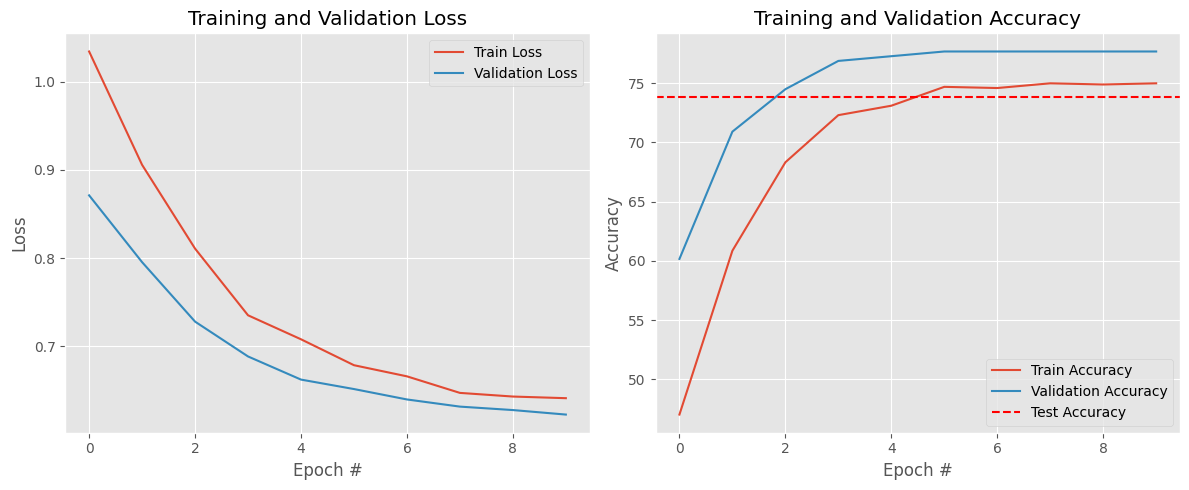

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate')
learning_rate = study.best_params.get('learning_rate')
model = FCNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader)


In [ ]:
# save model
torch.save(model, os.path.join(WORKING_PATH, OUTPUTDIR, NAMESTUDY + '_model.pth'))